**In this analysis, game data from a total of 2559 regular season NFL games covering a span of ten years from 2010-2019 is considered, obtained from http://pro-football-reference.com. The aim of this regression analysis is to predict the total points in a given NFL contest based on game conditions and statistics from the participating teams averaged over the previous six games. Only contests taking place from the seventh week of the season to the last week of the regular season are considered for prediction, totalling 1734 games. A description of the features used in this analysis follows.**

**Descriptive Features** - Used solely to describe the contest in question
 * Home_Team - The name of the home team in the contest
 * Vis_Team - The name of the visiting team in the contest
 * H_Game - The number of points scored by the home team in the contest
 * V_Game - The number of points scored by the visiting team in the contest
 
**Analytical Features** - Features used in analysis
 * Tot_Pts - Total Points of the contest. **This is our target variable.**
 * Over/Under - The predicted total points of the contest from professional bookmakers.
 
*Averaged Features* - Statistics averaged over previous five contests. In the columns, prefix "H_" stands for Home Team and "V_" stands for Visiting Team
 * Pts - Points scored
 * Pts_Opp - Points scored by opponent
 * Off_Pass - Offensive passing yards
 * Pass_Metric - Average of offensive passing rank (32 - best, 1 - worst) and defensive passing rank of opponent (1 - best, 32 - worst)
 * Off_Rush - Offensive rushing yards
 * Rush_Metric - Average of offensive rushing rank and defensive rushing rank of opponent
 * Def_Pass - Passing yards given up on defensive
 * Def_Rush - Rushing yards given up on defensive
 * TD - Touchdowns scored
 * TD_on_Def - Touchdowns scored by defense
 * FG_Pct - Percentage of field goals made vs. field goals attempted
 * RZ_Pct - Percentage of red zone possessions resulting in a touchdown (red zone possession is possession reaching opponent's 20 yard line)
 * Def_RZ_Pct - Defensive percentage of red zone possessions giving up a touchdown
 * Poss - Time of possession
 * Plays - Total number of plays
 * TO_Gain - Number of turnovers gained by defense
 * TO_Lost - Number of turnovers lost by offense
 * Yds_Pen - Number of yards penalized
 * Sacks_Def - Sacks earned by defense
 * Tackles_Loss - Number of tackles for loss earned by defense
 * Kickret - Return yards from kickoff
 * Puntret - Return yards from punt
 
*Game Conditions* - Conditions of the contest in question
 * Temperature - Temperature of the contest at kickoff
 * surface - The surface on which the contest was played

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error

In [4]:
sns.set(font_scale=1.4)

In [5]:
teams = {'Atlanta Falcons':'atl','Buffalo Bills':'buf','Carolina Panthers':'car','Chicago Bears':'chi',
         'Cincinnati Bengals':'cin','Cleveland Browns':'cle','Indianapolis Colts':'clt',
         'Arizona Cardinals':'crd','Dallas Cowboys':'dal','Denver Broncos':'den','Detroit Lions':'det',
         'Green Bay Packers':'gnb','Houston Texans':'htx','Jacksonville Jaguars':'jax',
         'Kansas City Chiefs':'kan','Miami Dolphins':'mia','Minnesota Vikings':'min','New Orleans Saints':'nor',
         'New England Patriots':'nwe','New York Giants':'nyg','New York Jets':'nyj','Tennessee Titans':'oti',
         'Philadelphia Eagles':'phi','Pittsburgh Steelers':'pit','Oakland Raiders':'rai',
         'St. Louis Rams':'ram','Los Angeles Rams':'ram','Baltimore Ravens':'rav',
         'San Diego Chargers':'sdg','Los Angeles Chargers':'sdg','Seattle Seahawks':'sea',
         'San Francisco 49ers':'sfo','Tampa Bay Buccaneers':'tam','Washington Redskins':'was'}

In [104]:
num = 6 # number of games averaged over

In [7]:
import matplotlib as mpl
from matplotlib import cm

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

In [8]:
def combine_dummies(df, name, combine_cols):
    for col in combine_cols:
        ind=df[df[col]==1].index
        df.loc[ind,name] = col
        df.drop(col,axis=1,inplace=True)
    return df

In [9]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [10]:
def weekofgame(game):
    from datetime import timedelta, datetime as dt
    day_of_week={2:0,3:1,4:2,5:3,6:4,0:5,1:6} #day of week starts on Wednesday
    date = dt.strptime(game[0:8],'%Y%m%d')
# .weekday() returns the day of the week for datetime.datetime   
    beg_week = date - timedelta(days=day_of_week[date.weekday()])
    fmt = lambda x: str(x) if x >= 10 else '0'+str(x)
    return(fmt(beg_week.month)+fmt(beg_week.day))

In [11]:
def get_year(code):
    if (code[4:6] == '01'):
        year = str(int(code[0:4])-1)
    else:
        year = str(int(code[0:4]))
    return year

In [12]:
def get_mapping(group,n):
    d={}
    keys = sorted(group['Week_Beg'].unique())
    values = [i for i in range((n+1),(n+1)+len(keys))]
    for key,value in zip(keys,values):
        d[key] = value
    return d

In [13]:
def bootstrap(data,n,func):
    n_replicates = 10000
    arr = np.empty(n_replicates)
    for i in range(n_replicates):
        rows = np.random.permutation(data.index)
        ind = data[rows[0:n]].index
        arr[i] = func(data[ind])
    return arr

In [14]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [15]:
def diff_of_means(data1, data2):
    """Difference in means of two arrays."""

    # The difference of means of data1, data2: diff
    diff = np.mean(data1) - np.mean(data2)

    return diff

In [16]:
def permuted(data1, data2, func):
    n_replicates = 10000
    arr = np.empty(n_replicates)
    for i in range(n_replicates):
        perm1, perm2 = permutation_sample(data1,data2)
        arr[i] = func(perm1, perm2)
    return arr

In [17]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [18]:
def ou_accuracy(actu,pred):
    global dfall
    ou = dfall.loc[actu.index,'Over/Under']
    if not((len(actu) == len(pred)) & (len(pred) == len(ou))):
        if (len(actu) != len(pred)):
            raise ValueError(f'Length mismatch among arguments: actual != predicted ({len(actu)} != {len(pred)})')
        else:
            raise ValueError(f'Length mismatch among arguments: predicted != Over/Under ({len(pred)} != {len(ou)})')
    else:
        corr = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
        tot = (actu<ou).sum() + (actu>ou).sum()
        return corr/tot

In [19]:
def regress(reg,Xtrain,Xtest,ytrain,ytest,cv=5,print_metrics=True,print_coef=True,return_metrics=False):
    robust = RobustScaler()
    sca_train = robust.fit_transform(Xtrain)
    sca_test = robust.transform(Xtest)
    val = cross_validate(reg, sca_train, ytrain, cv=cv, return_estimator=True,
                                scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
                                        'acc':make_scorer(ou_accuracy,greater_is_better=True)})
    acc = (np.mean(val['test_acc']),np.std(val['test_acc']))
    mae = (np.mean(-val['test_mae']),np.std(-val['test_mae']))
    best_estimator = val['estimator'][val['test_mae'].argmax()]

    ypred=best_estimator.predict(sca_test)
    mae_test=mean_absolute_error(ytest,ypred)
    acc_test = ou_accuracy(ytest,ypred)
    sorted_coef = get_coef(best_estimator.coef_,Xtrain.columns)
    if print_metrics:
        print(f'MAE_train = {mae[0]:.3f}±{mae[1]:.3f}, Accuracy = {acc[0]:.3f}±{acc[1]:.3f}')
        print(f'MAE_test = {mae_test:.3f}, Accuracy_test = {acc_test:.3f}')
    if print_coef:
        print(sorted_coef)
    if return_metrics:
        return mae_test,acc_test
    else:
        return

In [88]:
def cross_valid(reg, X, y, cv=5):
    acc = np.empty(cv)
    mae = np.empty(cv)
    Xmaster = np.array_split(X,cv)
    ymaster = np.array_split(y,cv)
    for i in range(cv):
        xlist, ylist = list(Xmaster), list(ymaster)
        xtest, ytest = xlist.pop(i), ylist.pop(i)
        xtrain = pd.concat(xlist)
        ytrain = pd.concat(ylist)
        reg.fit(xtrain,ytrain)
        ypred = reg.predict(xtest)
        acc[i] = ou_accuracy(ytest,ypred)
        mae[i] = mean_absolute_error(ytest,ypred)
#    print(mae,acc)
    return (np.mean(mae),np.std(mae)), (np.mean(acc), np.std(acc))

In [20]:
def get_coef(coef_,cols):
    coef = pd.DataFrame(coef_, cols, columns=['LR Coefficient'])
    ind=np.flip(np.argsort(abs(coef_)))
    return coef.iloc[ind]

In [21]:
path = 'data/df_complete.pkl'
with open(path,'rb') as f:
    dfall = pickle.load(f)

In [22]:
turf=['a_turf','astroplay','fieldturf','sportturf','matrixturf']

In [105]:
path = 'data/df_working'+str(num)+'.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)

In [24]:
dfgame.drop(turf,axis=1,inplace=True)

In [25]:
from sklearn.model_selection import train_test_split

train_ratio = 0.85
#validation_ratio = 0.15
test_ratio = 0.15

X_show = dfgame.copy(deep=False)
y = np.ravel(dfgame['Tot_Pts'])
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
# 70% split for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 77)
# # 15%, 15% split for validation, test data
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
#                                                 test_size = test_ratio/(test_ratio + validation_ratio), random_state = 77)
X_show = X_show.loc[X_train.index]

In [26]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

**The barplot demonstrates the quantized nature of football scoring. The significant advantage of the home team is indicated in the scoring as well as in the pie chart.** 

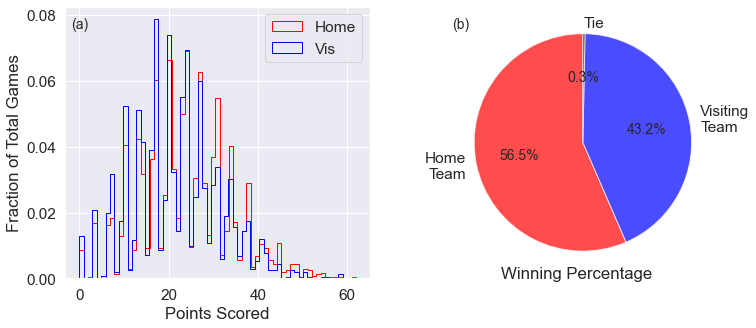

In [32]:
scores = dfall[['H_Game','V_Game']].rename({'H_Game':'Home','V_Game':'Vis'},axis=1)
fig1 = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
_ = plt.xlabel('Points Scored',fontsize='large')
_ = plt.ylabel('Fraction of Total Games',fontsize='large')
_ = plt.hist(scores['Home'],bins=63,density=True,histtype='step',ec='red',alpha=1.0,
         label='Home')
_ = plt.hist(scores['Vis'],bins=60,density=True,histtype='step',ec='blue',alpha=1.0,
         label='Vis')
_ = plt.legend(loc='upper right')
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes)
ax2 = plt.subplot(1,2,2)
win = np.array([(scores['Home'] > scores['Vis']).sum(),(scores['Home'] < scores['Vis']).sum(),
                 (scores['Home'] == scores['Vis']).sum()])
labels = 'Home'+'\n'+'Team', 'Visiting'+'\n'+'Team', 'Tie'
colors = ('red','blue','black')
alpha = 0.7
p = plt.pie(win/sum(win),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,startangle=90)
for i in range(3):
    p[0][i].set_alpha(alpha)
_ = plt.text(0.20,0.00,'Winning Percentage',transform=ax2.transAxes,fontsize='large')
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes)
fig1.show()
fig1.savefig('plots/fig1.png',bbox_inches='tight')

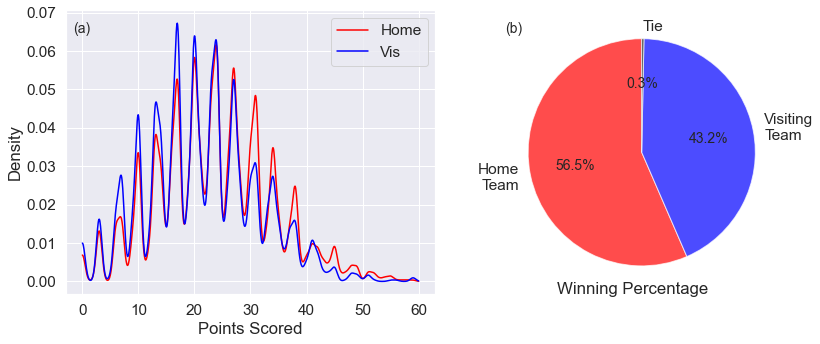

In [34]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity

scores = dfall[['H_Game','V_Game']].rename({'H_Game':'Home','V_Game':'Vis'},axis=1)
fig1 = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
bandwidth=0.5
x_d = np.linspace(0,60,1000)
x = scores['Home']
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(x[:,None])
logprob = kde.score_samples(x_d[:,None])
#plt.fill_between(x_d, np.exp(logprob), alpha=0.5,color='red')
_ = plt.xlabel('Points Scored',fontsize='large')
_ = plt.ylabel('Density',fontsize='large')
_ = plt.plot(x_d, np.exp(logprob), color='red',label='Home')
# _ = plt.hist(scores['Home'],bins=63,density=True,histtype='step',ec='red',alpha=1.0,
#          label='Home')
# _ = plt.hist(scores['Vis'],bins=60,density=True,histtype='step',ec='blue',alpha=1.0,
#          label='Vis')
x = scores['Vis']
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(x[:,None])
logprob = kde.score_samples(x_d[:,None])
_ = plt.plot(x_d, np.exp(logprob), color='blue',label='Vis')
_ = plt.legend(loc='upper right')
#plt.fill_between(x_d, np.exp(logprob), alpha=0.5,color='blue')
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes)
ax2 = plt.subplot(1,2,2)
win = np.array([(scores['Home'] > scores['Vis']).sum(),(scores['Home'] < scores['Vis']).sum(),
                 (scores['Home'] == scores['Vis']).sum()])
labels = 'Home'+'\n'+'Team', 'Visiting'+'\n'+'Team', 'Tie'
colors = ('red','blue','black')
alpha = 0.7
p = plt.pie(win/sum(win),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,startangle=90)
for i in range(3):
    p[0][i].set_alpha(alpha)
_ = plt.text(0.20,0.00,'Winning Percentage',transform=ax2.transAxes,fontsize='large')
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes)
fig1.tight_layout()
fig1.show()
fig1.savefig('plots/fig1.png',bbox_inches='tight')

**We can see the range of total score is much larger than that of the Over/Under (3X) with a positive correlation of 0.28.**

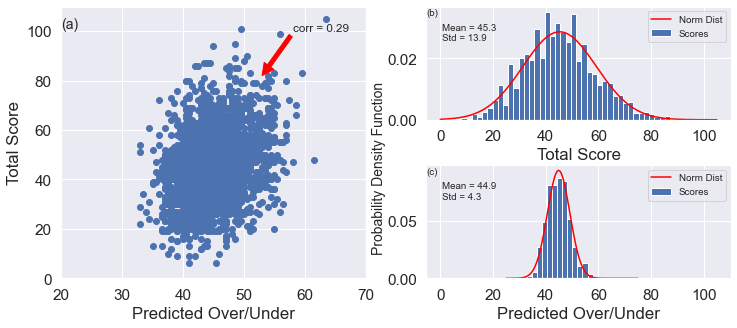

In [35]:
import matplotlib.gridspec as gridspec
from scipy import stats   

fig2 = plt.figure(figsize=(12,5))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

inner_l = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
ax = plt.Subplot(fig2, inner_l[0])
ax.scatter(dfall['Over/Under'],dfall['Tot_Pts'])
ax.set_xlim((20,70))
ax.set_ylim((0,110))
ax.set_xlabel('Predicted Over/Under')
ax.set_ylabel('Total Score')
ax.annotate('corr = 0.29',xy=(53,82),xytext=(58,100),arrowprops={'color':'red'},fontsize='small')
ax.text(0.00,0.92,'(a)',transform=ax.transAxes)

fig2.add_subplot(ax)

inner_r = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[1],hspace=0.4)
j=0
mu = np.mean(dfall['Tot_Pts'])
sig = np.std(dfall['Tot_Pts'])
ax0 = plt.Subplot(fig2, inner_r[j])
ax0.set_xlabel('Total Score')
ax0.hist(dfall['Tot_Pts'],bins=50,density=True,label='Scores')
xx = np.linspace(0,105,1000)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
ax0.plot(xx,yy,color='red',label='Norm Dist')
ax0.legend(loc='upper right',fontsize='x-small')
ax0.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax0.transAxes,fontsize='x-small')
ax0.text(0.00,0.92,'(b)',transform=ax0.transAxes,fontsize='x-small')
fig2.add_subplot(ax0)
j=1
mu = np.mean(dfall['Over/Under'])
sig = np.std(dfall['Over/Under'])
ax1 = plt.Subplot(fig2, inner_r[j], sharex=ax0)
ax1.hist(dfall['Over/Under'],bins=16,density=True,label='Scores')
xx = np.linspace(25,75,500)
yy = stats.norm.pdf(xx,loc=np.mean(dfall['Over/Under']),scale=np.std(dfall['Over/Under']))
ax1.plot(xx,yy,color='red',label='Norm Dist')
ax1.legend(loc='upper right',fontsize='x-small')
ax1.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax1.transAxes,fontsize='x-small')
ax1.text(0.00,0.92,'(c)',transform=ax1.transAxes,fontsize='x-small')
fig2.add_subplot(ax1)
fig2.text(0.485,0.20,'Probability Density Function',rotation='vertical')
ax1.set_xlabel('Predicted Over/Under')
fig2.show()
fig2.savefig('plots/fig2.png',bbox_inches='tight')

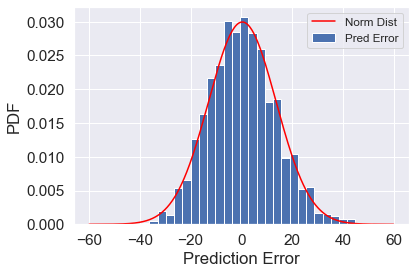

In [36]:
error = dfall['Tot_Pts'] - dfall['Over/Under']

mu = np.mean(error)
sig = np.std(error)
xx = np.linspace(-60,60,500)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
fig3 = plt.figure()
_ = fig3.add_subplot(1,1,1)
_ = plt.xlabel('Prediction Error')
_ = plt.ylabel('PDF')
_ = plt.hist(error,bins=28,density=True,label='Pred Error')
_ = plt.plot(xx,yy,color='red',label='Norm Dist')
_ = plt.legend(loc='upper right',fontsize='small')
fig3.show()
fig3.savefig('plots/fig3.png',bbox_inches='tight')

**This boxplot shows the symmetry of the error data around 0 and the larger number of positive outliers in the Over/Under prediction error.** 

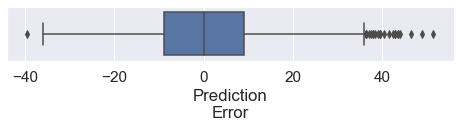

In [37]:
fig4 = plt.figure(figsize=(8,1))
error = pd.Series(error,name='Prediction'+'\n'+'Error')
_ = sns.boxplot(error, orient='h')
fig4.show()
fig4.savefig('plots/fig4.png',bbox_inches='tight')

**There is remarkable symmetry in the Over/Under prediction error, as well as in the Over vs. Under wins. This symmetry is also revealed in the median error, although a greater number of outliers to the upside is reflected in the average error.** 

The median and average errors for the Over are 9.0 and 11.1 points
The median and average errors for the Under are -9.0 and -10.3 points


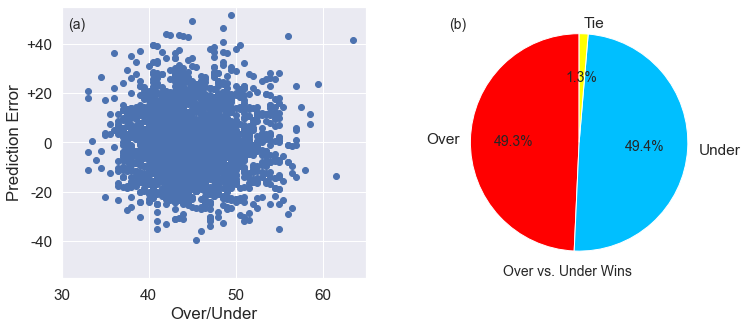

In [38]:
import matplotlib.ticker as tick
fig5, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5)) 
error = dfall['Tot_Pts'] - dfall['Over/Under']
ax1.set_ylim(-55,55)
ax1.set_xlim(30,65)
ax1.set_xlabel('Over/Under')
ax1.set_ylabel('Prediction Error')
ax1.scatter(dfall['Over/Under'],error)
def y_tk_fmt(x,y):
    if x > 0:
        return '{:+d}'.format(int(x))
    else:
        return '{:d}'.format(int(x))
ax1.yaxis.set_major_formatter(tick.FuncFormatter(y_tk_fmt))
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes,fontsize='medium')
o_u = np.array([(dfall['Tot_Pts'] > dfall['Over/Under']).sum(),
                (dfall['Tot_Pts'] < dfall['Over/Under']).sum(),
                 (dfall['Tot_Pts'] == dfall['Over/Under']).sum()])
labels = 'Over','Under','Tie'
colors = ('red','deepskyblue','yellow')
ax2.pie(o_u/sum(o_u),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,
        startangle=90)
ax2.text(0.22,0.01,'Over vs. Under Wins',transform=ax2.transAxes)
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes,fontsize='medium')
fig5.show()
fig5.savefig('plots/fig5.png',bbox_inches='tight')
import statistics
pos = error[error > 0]
neg = error[error < 0]
print('The median and average errors for the Over are {0:.1f} and {1:.1f} points'
      .format(pos.median(),pos.mean()))
print('The median and average errors for the Under are {0:.1f} and {1:.1f} points'
      .format(neg.median(),neg.mean()))

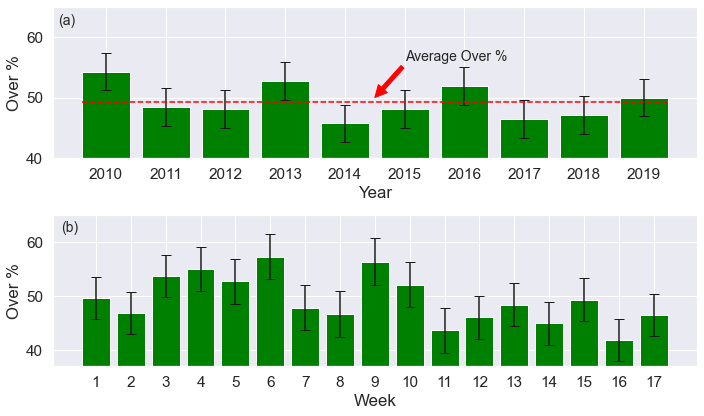

In [58]:
Q3=error.quantile(0.75)
Q1=error.quantile(0.25)
IQR = Q3-Q1
outliers = dfall.loc[error > 1.5*IQR,:]
outlier_year = pd.Series([int(x[0:4]) for x in outliers.index])
year_counts = outlier_year.value_counts().sort_index()

# Calculate percentage of 'Overs' by year 
year = pd.DataFrame(index=dfall.index,columns=['Year'])
for ind in dfall.index: 
    year.loc[ind,'Year'] = int(get_year(ind))
    year.loc[ind,'Team'] = ind[-3:]
year['Over'] = dfall['Tot_Pts'] > dfall['Over/Under']
over_count_year = year['Over'].groupby(year.Year).mean()
year['Week'] = dfall['Week']
over_count_week = year['Over'].groupby(year.Week).mean()

fig6 = plt.figure(figsize=(10,6))
_ = fig6.add_subplot(2,1,1)
_ = plt.xlabel('Year')
_ = plt.ylabel('Over %')
x = year_counts.index
err = 100*np.sqrt(0.5*0.5/year['Over'].groupby(year.Year).count())
_ = plt.bar(x,over_count_year.values*100,color='green',yerr=err,capsize=5,
       tick_label=[str(i) for i in range(2010,2020)])
#_ = plt.errorbar(x,over_count_year.values*100,yerr=err)
_ = plt.ylim(40,65)
_ = plt.hlines(49.3,2009.6,2019.4,linestyle='dashed',colors='red')
_ = plt.annotate('Average Over %',xy=(2014.5,50),xytext=(2015,56),arrowprops={'color':'red'})
_ = plt.text(2009.2,62,'(a)',fontsize='medium')
_ = fig6.add_subplot(2,1,2)
_ = plt.xlabel('Week')
_ = plt.ylabel('Over %')
err = 100*np.sqrt(0.5*0.5/year['Over'].groupby(year.Week).count())
_ = plt.bar(range(1,18),over_count_week.values*100,color='green',yerr=err,capsize=5,
       tick_label=[str(i) for i in range(1,18)])
#_ = plt.errorbar()
_ = plt.ylim(37,65)
_ = plt.text(0.01,62,'(b)',fontsize='medium')
fig6.tight_layout()  
fig6.show()
fig6.savefig('plots/fig6.png')

**There is a significant difference in the Over % in Weeks 1-10 versus Weeks 11-17.** 

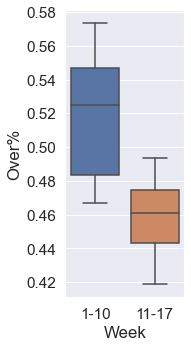

In [68]:
data = pd.DataFrame(over_count_week.values,columns=['Over%'])
data.loc[0:9,'Week'] = '1-10'
data.loc[10:16,'Week'] = '11-17'

fig7 = plt.figure(figsize=(3,5))
_ = fig.add_subplot(1,1,1)
_ = sns.boxplot(x='Week',y='Over%',data=data,orient='v')
plt.tight_layout()
plt.show()
fig7.savefig('plots/fig7.png')

Confidence interval for Weeks 1-10 is (0.44375, 0.59375)
Confidence interval for Weeks 11-17 is (0.3875, 0.53125)


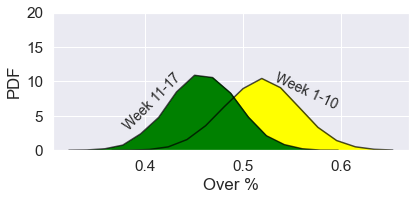

In [84]:
early_over_means=bootstrap(early['Tot_Pts']>early['Over/Under'],160,np.mean)
late_over_means=bootstrap(late['Tot_Pts']>late['Over/Under'],160,np.mean)

print('Confidence interval for Weeks 1-10 is {}'.format((np.percentile(early_over_means,2.5),np.percentile(early_over_means,97.5))))
print('Confidence interval for Weeks 11-17 is {}'.format((np.percentile(late_over_means,2.5),np.percentile(late_over_means,97.5))))

fig = plt.figure(figsize=(6,3))
_ = fig.add_subplot(1,1,1)
bins=16
n,x = np.histogram(early_over_means,bins=bins,density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n,color='black',alpha=0.7) ## using bin_centers rather than edges
plt.fill_between(bin_centers,n,color='yellow')

n,x = np.histogram(late_over_means,bins=bins,density=True)
#_ = plt.hist(late_over_means,bins=15,density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n,color='black',alpha=0.7) ## using bin_centers rather than edges
plt.fill_between(bin_centers,n,color='green')
_ = plt.ylim(0,20)
_ = plt.text(0.375,3,'Week 11-17',rotation=45)
_ = plt.text(0.53,6,'Week 1-10',rotation=335)
_ = plt.xlabel('Over %')
_ = plt.ylabel('PDF')
fig.tight_layout()
plt.show()

**The cause of this difference seems to be related to the decrease in total points late in the season, which is not matched by a corresponding decrease in Over/Under. A decrease in passing yards is also noted, which is aligned with the decline in temperature experienced during this time.**

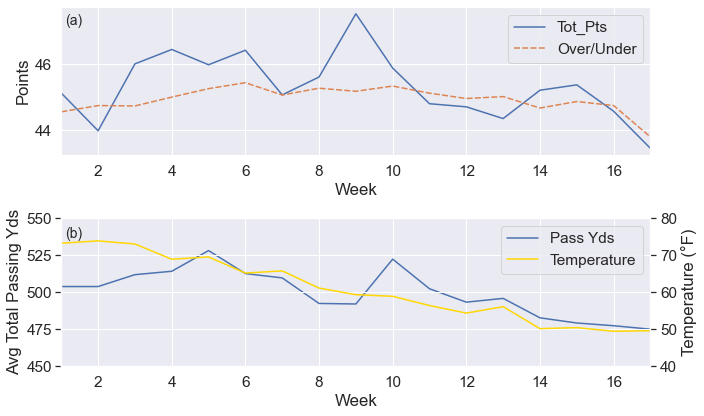

In [63]:
path=f'data/df_raw.pkl'
with open(path,'rb') as f:
    dfraw=pickle.load(f)
codes = dfraw.index.levels[1]
codes = set(codes)
pyds = pd.DataFrame(index=codes,columns=['Home_Pass_Yds','Vis_Pass_Yds','Tot_Pass_Yds','Wind','Temperature','Humidity'])
for col in pyds.columns: pyds[col]=pd.to_numeric(pyds[col])
pyds['Week'] = dfall['Week']
for code in pyds.index:
    home = code[-3:]
    pyds.loc[code,'Home_Pass_Yds'] = dfraw.loc[(home,code),'Yds_Off_Pass']
    pyds.loc[code,'Vis_Pass_Yds'] = dfraw.loc[(teams[dfraw.loc[(home,code),'Opponent']],code),'Yds_Off_Pass']
    pyds.loc[code,'Tot_Pass_Yds'] = pyds.loc[code,'Home_Pass_Yds'] + pyds.loc[code,'Vis_Pass_Yds']
    pyds.loc[code,'Wind'] = dfall.loc[code,'Wind']
    pyds.loc[code,'Temperature'] = dfall.loc[code,'Temperature']
    pyds.loc[code,'Humidity'] = dfall.loc[code,'Humidity']

wind_by_week = pyds['Wind'].groupby(pyds.Week).mean()
temp_by_week = pyds['Temperature'].groupby(pyds.Week).mean()
hum_by_week = pyds['Humidity'].groupby(pyds.Week).mean()

tp=dfall[['Tot_Pts','Over/Under','Week']]
tp['Pass_Yds'] = dfall['H_Off_Pass'] + dfall['V_Off_Pass']
tp['Rush_Yds'] = dfall['H_Off_Rush'] + dfall['V_Off_Rush']
tpmelt=pd.melt(tp,id_vars=['Week'],value_vars=['Tot_Pts','Over/Under','Pass_Yds','Rush_Yds'],
              var_name='Feature')
tppivot=pd.pivot_table(tp,index=['Week'],values=['Tot_Pts','Over/Under','Pass_Yds','Rush_Yds'],aggfunc='mean')
tppivot.loc[1:16,['Pass_Yds','Rush_Yds']]=tppivot.loc[2:17,['Pass_Yds','Rush_Yds']]
tppivot.loc[1,'Pass_Yds'] = tppivot.loc[2,'Pass_Yds']

# Get Passing and Rushing Yards for Final Week of Season
py = 0
ry = 0
num = 0
for year in range(2010,2020):
    path=f'data/df_step2_{str(year)}.data'
    with open(path,'rb') as f:
        raw=pickle.load(f)
    codes = [raw.loc[team].index[-1] for team in raw.index.levels[0]]
    codes = set(codes)
    for code in codes:
        team = code[-3:]
        py += raw.loc[(team,code),'Yds_Off_Pass'] + raw.loc[(team,code),'Yds_Def_Pass']
        ry += raw.loc[(team,code),'Yds_Off_Rush'] + raw.loc[(team,code),'Yds_Def_Rush']
    num += len(codes)
py = py/num
ry = ry/num
tppivot.loc[17,'Pass_Yds'] = py
tppivot.loc[17,'Rush_Yds'] = ry

fig8 = plt.figure(figsize=(10,6))
_ = fig8.add_subplot(2,1,1)
_ = sns.lineplot(data=tppivot[['Tot_Pts','Over/Under']])
_ = plt.xlim(1,17)
_ = plt.ylabel('Points')
_ = plt.text(1.1,47.2,'(a)',fontsize='medium')
ax1 = fig8.add_subplot(2,1,2)
ax1.plot(tppivot.index,tppivot['Pass_Yds'],label='Pass Yds')
ax1.set_xlabel('Week')
ax1.set_ylabel('Avg Total Passing Yds')
ax1.text(1.1,537,'(b)',fontsize='medium')
ax1.set_ylim(450,550)
ax1.set_xlim(1,17)
ax2 = ax1.twinx()
ax2.plot(range(1,18),temp_by_week,color='gold',label='Temperature')
ax2.set_ylabel('Temperature (°F)')
ax2.set_ylim(40,80)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
fig8.tight_layout()  
fig8.show()
fig8.savefig('plots/fig8.png')

**A one-sided t-test indicates that the differences in Over% between weeks 1-10 and weeks 11-17 are statistically significant, although the low Cohen's-D suggests the need for more data.**

In [70]:
import pingouin as pg
early = dfall[dfall['Week'] < 11]
late = dfall[dfall['Week'] >= 11]
res = pg.ttest(early['Tot_Pts']>early['Over/Under'],late['Tot_Pts']>late['Over/Under'],
               correction=True,tail='greater')
print(res)

               T          dof     tail     p-val        CI95%   cohen-d  \
T-test  2.969578  2357.912853  greater  0.001506  [0.03, inf]  0.118614   

         BF10     power  
T-test  7.149  0.907051  


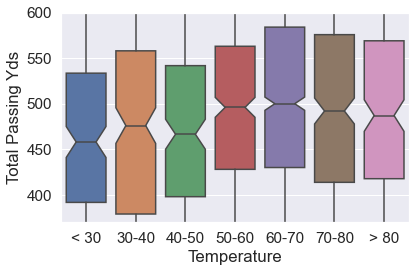

In [65]:
fig9 = plt.figure(figsize=(6,4))
_ = fig9.add_subplot(1,1,1)
bins = [-10,30,40,50,60,70,80,100]
pyds['Bin'] = pd.cut(pyds.Temperature,bins)
sns.boxplot(x='Bin',y='Tot_Pass_Yds',data=pyds,
            notch=True).set(xlabel='Temperature',ylim=(370,600),
                            ylabel='Total Passing Yds',xticklabels=['< 30','30-40','40-50','50-60','60-70','70-80','> 80'])
plt.tight_layout()
plt.show()
fig9.savefig('plots/fig9.png')

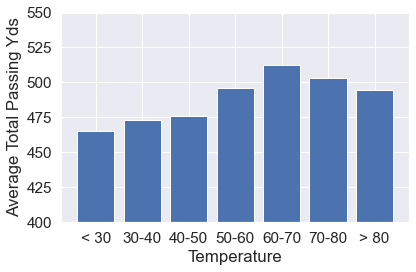

In [67]:
fig = plt.figure(figsize=(6,4))
_ = fig.add_subplot(1,1,1)
bins = [-10,30,40,50,60,70,80,100]
grouped = pyds.groupby(pd.cut(pyds.Temperature,bins))
ind = np.arange(len(grouped['Tot_Pass_Yds'].mean()))
_ = plt.bar(ind,grouped['Tot_Pass_Yds'].mean().values)
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(400,550)
_ = plt.ylabel('Average Total Passing Yds')
_ = plt.xlabel('Temperature')
plt.tight_layout()
plt.show()

   **The variation in wind, temperature, and humidity by week are shown below.**

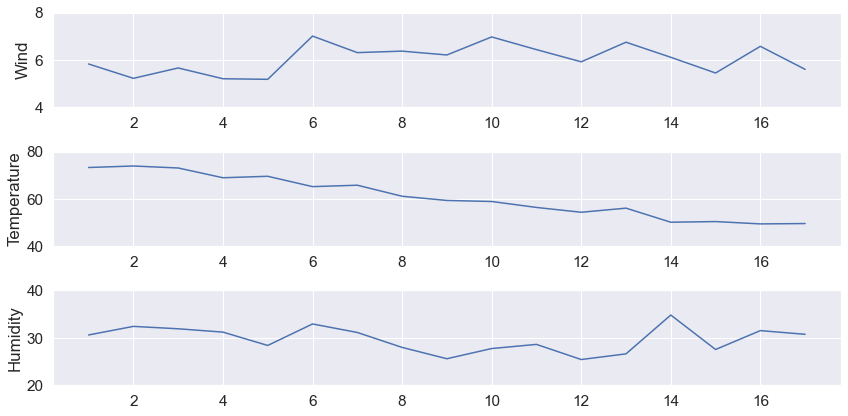

In [66]:
fig = plt.figure(figsize=(12,6))
_ = fig.add_subplot(3,1,1)
_ = plt.plot(range(1,18),wind_by_week)
_ = plt.ylim(4,8)
_ = plt.ylabel('Wind')
# _ = plt.text(1.1,47.2,'(a)',fontsize='medium')
_ = fig.add_subplot(3,1,2)
_ = plt.plot(range(1,18),temp_by_week)
# _ = plt.xlabel('Week')
_ = plt.ylabel('Temperature')
_ = plt.ylim(40,80)
# _ = plt.text(1.1,537,'(b)',fontsize='medium')
_ = fig.add_subplot(3,1,3)
_ = plt.plot(range(1,18),hum_by_week)
_ = plt.ylabel('Humidity')
_ = plt.ylim(20,40)
fig.tight_layout()  
fig.show()

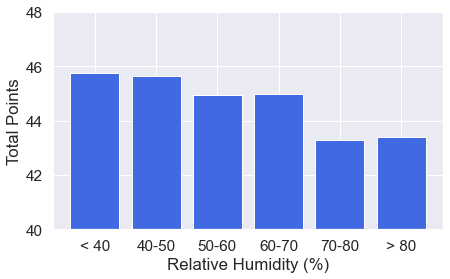

In [820]:
fig77 = plt.figure(figsize=(7,4))
bins = [0,40,50,60,70,80,100]
grouped = dfall.groupby(pd.cut(dfall.Humidity,bins))
# counts = grouped['Tot_Pts'].count().values
# alp = counts/max(counts)
# colors = [(0,0,0.5,alp[a]) for a in range(len(alp))]
ind = np.arange(len(grouped['Humidity'].mean()))
_ = plt.bar(ind,grouped['Tot_Pts'].mean().values,color='royalblue')
_ = plt.xticks(ind,labels=('< 40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(40,48)
_ = plt.xlabel('Relative Humidity (%)')
_ = plt.ylabel('Total Points')
fig.tight_layout()
plt.show()
fig77.savefig('plots/fig77.png')

**The following correlation matrix reveals that there seems to be a much greater correlation between the scoring history of the teams and the predicted over/under (0.45,0.46) than between the scoring history and the actual total score of the predicted game (0.14,0.13). In addition, there is little to no correlation between the opposing teams' scores of the last five games and the total score of the game in question (0.00,0.05). Also revealed is that there is significant correlation between red zone percentage and scoring history, as expected, but little correlation with scoring history and field goal percentage. The importance of red zone percentage is reflected in the over/under prediction, but less so in the actual total score.**

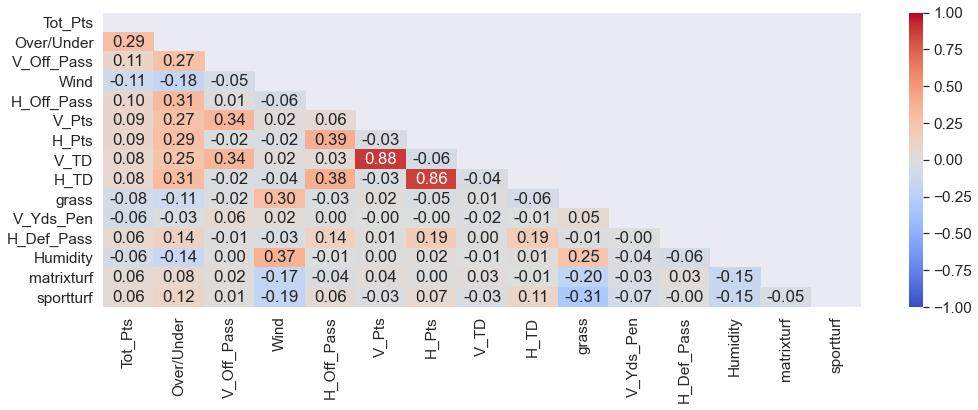

In [559]:
fig14 = plt.figure(figsize=(15,6))
ax = fig14.add_subplot(1,1,1)

df = dfall.loc[X_show.index]
#df = X_show
cols = df.columns.drop(['Home_Team','Vis_Team','H_Game','V_Game'])
corrs = [np.abs(df['Tot_Pts'].corr(df[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))]

Top = df[newcols[0:15]]
mask = np.triu(Top.corr())
sns.set(font_scale=1.4)
sns.heatmap(Top.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
fig14.tight_layout()
fig14.show()
fig14.savefig('plots/fig14.png')

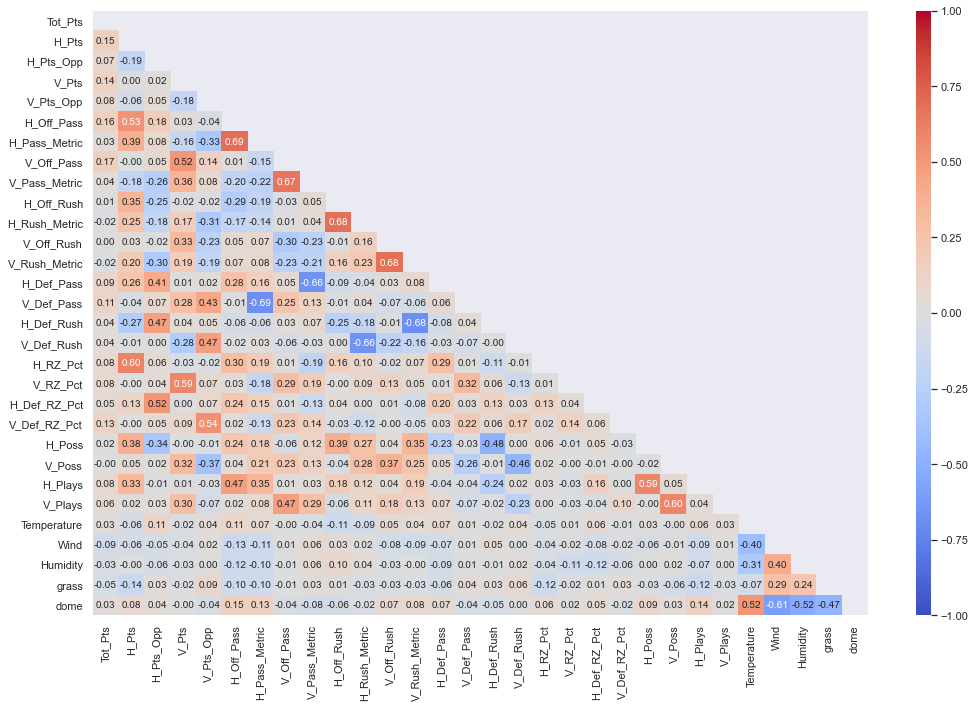

In [549]:
fig15 = plt.figure(figsize=(15,10))
ax = fig15.add_subplot(1,1,1)

dropped = ['Home_Team','Vis_Team','H_Game','V_Game','Over/Under']
                 
cols=X_show.columns.drop(dropped)
#corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
#sortcorr = sorted(corrs,reverse=True)
#mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
#newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Stats=X_show[cols]
coeffs = Stats.corr()
moretodrop = []
for col in cols:
    if (col != 'Tot_Pts'):
        max_coef = coeffs.loc[col,np.abs(coeffs.loc[col]).rank(ascending=False) == 2].values[0] # neglect self-correlation
        if np.abs(max_coef) < 0.4: moretodrop.append(col)
coeffs = coeffs.drop(moretodrop).drop(moretodrop,axis=1)
mask = np.triu(coeffs)
#sns.set(font_scale=0.8)
sns.set(font_scale=1.0)
sns.heatmap(coeffs,vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',cbar_kws={'aspect':40},fmt='.2f',annot_kws={"size": 10})
fig15.tight_layout()
fig15.show()
fig15.savefig('plots/fig15.png')

In [89]:
LR = linear_model.LinearRegression()
robust = RobustScaler()
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score,cross_validate

In [172]:
domed = X_show[X_show['dome']==1]
outside = X_show[X_show['dome']==0]

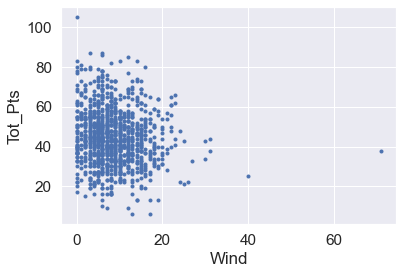

In [173]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
_ = plt.plot(outside['Wind'],outside['Tot_Pts'],marker='.',linestyle='None')
fig.show()

In [174]:
print(X_show['Tot_Pts'].corr(X_show['Wind']))
print(X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(np.log(X_show['Wind'])))
print(X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(np.sqrt(X_show['Wind'])))
print(X_show[X_show['Wind'] > 0]['Tot_Pts'].corr((X_show['Wind'])**(-1.0)))
print(X_show[X_show['Wind'] > 0]['Tot_Pts'].corr((X_show['Wind'])**(-0.5)))

-0.10503186504651046
-0.11904889589650075
-0.11375883008230511
0.11618033708929379
0.12005030510087619


In [152]:
vifdrop=['V_Off_Pass','H_Pts','V_Pts','H_RZ_Pct','V_RZ_Pct','H_Poss','V_Poss','V_Plays','H_Plays','H_FG_Pct','V_FG_Pct','V_Pass_Metric',
         'V_Rush_Metric','H_Pass_Metric','H_Rush_Metric','H_Kickret','V_Kickret','Week','H_Puntret',
         'V_Puntret','H_Def_RZ_Pct','V_Def_RZ_Pct','V_Pts_Opp','H_Pts_Opp','H_Off_Rush','V_Off_Rush',
        'H_Def_Pass','V_Def_Pass','H_Def_Rush','V_Def_Rush','H_Sacks_Def','Temperature','V_Tackles_Loss','H_Tackles_Loss','H_Yds_Pen','V_Yds_Pen',
        'V_TO_Lost','H_TO_Lost','H_TO_Gain','V_TO_Gain','Humidity','V_TD_on_Def','H_TD_on_Def','V_Sacks_Def']

In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Use training ratio of 85% for 5-fold cross-validation
train_ratio = 0.85

path = 'data/df_working6.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(turf,axis=1)
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF Factor'] = [variance_inflation_factor(X_train.values,i) for i in range(len(X_train.columns))]
print(np.sqrt(np.mean(vif['VIF Factor']**2)))
vif.round(2).sort_values(by='VIF Factor',ascending=False)

3.833396321107722


,Features,VIF Factor
0,H_Off_Pass,6.04
1,Wind,2.92
2,grass,2.84
3,dome,2.39


In [155]:
regress(LR,X_train,X_test,y_train,y_test,cv=5)

MAE_train = 10.909±0.491, Accuracy = 0.512±0.014
MAE_test = 10.969, Accuracy_test = 0.505
            LR Coefficient
H_Off_Pass        2.794816
dome             -2.699052
Wind             -2.675355
grass            -1.090658


In [191]:
X['Wind_Adj'] = X['Wind']
X.drop('Wind',axis=1,inplace=True)
X['Wind_Adj'] = X['Wind_Adj'].replace({0:1})
X['Wind_Adj'] = X['Wind_Adj']**(-0.5)

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF Factor'] = [variance_inflation_factor(X_train.values,i) for i in range(len(X_train.columns))]
print(np.sqrt(np.mean(vif['VIF Factor']**2)))
vif.round(2).sort_values(by='VIF Factor',ascending=False)

8.458114647294696


,Features,VIF Factor
3,Wind_Adj,13.41
0,H_Off_Pass,8.77
2,dome,4.59
1,grass,2.85


In [197]:
path = 'data/df_working5.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X[['H_Pts','V_Pts','V_Off_Pass','Wind','dome','H_Off_Pass','H_Def_Rush','grass','V_Def_Rush',
       'H_RZ_Pct','V_RZ_Pct','H_Sacks_Def']]
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
regress(LR,X_train,X_test,y_train,y_test,cv=5)

MAE_train = 10.676±0.396, Accuracy = 0.526±0.026
MAE_test = 10.818, Accuracy_test = 0.553
             LR Coefficient
V_Off_Pass         2.315625
H_Pts              2.202793
Wind              -2.181538
dome              -1.684290
grass             -1.530694
H_Off_Pass         1.485824
V_Pts              1.374465
V_Def_Rush         1.182012
H_Def_Rush         1.136085
H_Sacks_Def        0.345089
H_RZ_Pct          -0.252700
V_RZ_Pct          -0.198801


In [196]:
path = 'data/df_working5.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X[['H_Pts','V_Pts','V_Off_Pass','Wind','dome','H_Off_Pass','H_Def_Rush','grass','V_Def_Rush',
       'H_RZ_Pct','V_RZ_Pct','H_Sacks_Def']]
X['Wind_Adj'] = X['Wind']
X.drop('Wind',axis=1,inplace=True)
X['Wind_Adj'] = X['Wind_Adj'].replace({0:1})
X['Wind_Adj'] = X['Wind_Adj']**(-0.5)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
regress(LR,X_train,X_test,y_train,y_test,cv=5)

MAE_train = 10.677±0.398, Accuracy = 0.515±0.026
MAE_test = 10.856, Accuracy_test = 0.553
             LR Coefficient
Wind_Adj           5.276622
dome              -4.296742
V_Off_Pass         2.350458
H_Pts              2.227415
grass             -1.533290
H_Off_Pass         1.483669
V_Pts              1.404160
V_Def_Rush         1.224439
H_Def_Rush         1.141674
V_RZ_Pct          -0.340732
H_Sacks_Def        0.338426
H_RZ_Pct          -0.271621


12
MAE_train = 10.576±0.403, Accuracy = 0.536±0.023
MAE_test = 10.689, Accuracy_test = 0.575
             LR Coefficient
H_Pts              3.378431
V_Off_Pass         3.218525
Wind              -2.630468
dome              -2.131381
H_Off_Pass         1.684834
H_Def_Rush         1.481838
grass             -1.143125
V_Def_Rush         1.033738
H_RZ_Pct          -1.025498
V_RZ_Pct           0.818933
H_Sacks_Def        0.686804
V_Pts              0.262492


In [38]:
by_home = pd.DataFrame(index=teams.keys())
grouped_by_home = dfall.groupby(dfall['Home_Team'])
for key, item in grouped_by_home:
    by_home.loc[key,'Avg_Total_Points'] = item.Tot_Pts.mean()
    by_home.loc[key,'Std_Total_Points'] = item.Tot_Pts.std()
    by_home.loc[key,'Avg_Passing_Yds'] = item.H_Off_Pass.mean()
    by_home.loc[key,'Avg_Rushing_Yds'] = item.H_Off_Rush.mean()
    by_home.loc[key,'Avg_Passing_Def'] = item.H_Def_Pass.mean()
    by_home.loc[key,'Avg_Rushing_Def'] = item.H_Def_Rush.mean()
by_home['Avg_Total_Yds'] = by_home['Avg_Passing_Yds'] + by_home['Avg_Rushing_Yds']
by_home['Avg_Total_Def'] = by_home['Avg_Passing_Def'] + by_home['Avg_Rushing_Def']
by_home['Passing_Rank'] = by_home['Avg_Passing_Yds'].rank(ascending=False)
by_home['Rushing_Rank'] = by_home['Avg_Rushing_Yds'].rank(ascending=False)
by_home['Offense_Rank'] = by_home['Avg_Total_Yds'].rank(ascending=False)
by_home['Passing_Def_Rank'] = by_home['Avg_Passing_Def'].rank(ascending=False)
by_home['Rushing_Def_Rank'] = by_home['Avg_Rushing_Def'].rank(ascending=False)
by_home['Defense_Rank'] = by_home['Avg_Total_Def'].rank(ascending=False)
by_home = by_home.drop(['Avg_Passing_Yds','Avg_Rushing_Yds','Avg_Total_Yds',
                        'Avg_Passing_Def','Avg_Rushing_Def','Avg_Total_Def'],axis=1)

by_home.index.name='Team'
by_home=by_home.sort_values(by=['Avg_Total_Points'],ascending=False)
by_home.reset_index(drop=False,inplace=True)

In [199]:
tmpts = pd.DataFrame(index=pd.MultiIndex.from_product([teams.keys(),range(160)],
                                                    names=['Team','Game']),columns=['Points','Location'])
tmpts.sort_index(ascending=True, inplace=True)
for team in tmpts.index.levels[0]:
    home_games = len(dfall[dfall.Home_Team==team])
    tmpts.loc[(team,slice(0,home_games-1)),'Points'] = dfall.loc[dfall.Home_Team==team,'H_Game'].values
    tmpts.loc[(team,slice(0,home_games-1)),'Location'] = 'H'
    vis_games = len(dfall[dfall.Vis_Team==team])
    tmpts.loc[(team,slice(home_games,home_games+vis_games-1)),'Points'] = \
        dfall.loc[dfall.Vis_Team==team,'V_Game'].values
    tmpts.loc[(team,slice(home_games,home_games+vis_games-1)),'Location'] = 'A'
tmpts['Points'] = pd.to_numeric(tmpts['Points'])
tmpts = tmpts.reset_index(drop=False)
tmpts.loc[tmpts.Location=='H','mean_H']=tmpts[tmpts.Location=='H'].groupby('Team')['Points'].transform(np.mean)
tmpts.loc[tmpts.Location=='H','mean_A']=0
tmpts.loc[tmpts.Location=='A','mean_A']=tmpts[tmpts.Location=='A'].groupby('Team')['Points'].transform(np.mean)
tmpts.loc[tmpts.Location=='A','mean_H']=0
tmpts['mean_diff']=tmpts['mean_H']-tmpts['mean_A']
tmpts['meaned']=tmpts.groupby('Team')['mean_diff'].transform(np.mean)*2.0
tmpts=tmpts.sort_values('meaned',ascending=False).drop(['mean_H','mean_A','mean_diff','meaned'],axis=1)

In [200]:
totpts = pd.DataFrame(index=pd.MultiIndex.from_product([teams.keys(),range(160)],
                                                    names=['Team','Game']),columns=['Tot_Pts','Location'])
totpts.sort_index(ascending=True, inplace=True)
for team in totpts.index.levels[0]:
    home_games = len(dfall[dfall.Home_Team==team])
    totpts.loc[(team,slice(0,home_games-1)),'Tot_Pts'] = dfall.loc[dfall.Home_Team==team,'Tot_Pts'].values
    totpts.loc[(team,slice(0,home_games-1)),'Location'] = 'H'
    vis_games = len(dfall[dfall.Vis_Team==team])
    totpts.loc[(team,slice(home_games,home_games+vis_games-1)),'Tot_Pts'] = \
        dfall.loc[dfall.Vis_Team==team,'Tot_Pts'].values
    totpts.loc[(team,slice(home_games,home_games+vis_games-1)),'Location'] = 'A'
totpts['Tot_Pts'] = pd.to_numeric(totpts['Tot_Pts'])
totpts = totpts.reset_index(drop=False)
totpts.loc[totpts.Location=='H','mean_H']=totpts[totpts.Location=='H'].groupby('Team')['Tot_Pts'].transform(np.mean)
totpts.loc[totpts.Location=='H','mean_A']=0
totpts.loc[totpts.Location=='A','mean_A']=totpts[totpts.Location=='A'].groupby('Team')['Tot_Pts'].transform(np.mean)
totpts.loc[totpts.Location=='A','mean_H']=0
totpts['mean_diff']=totpts['mean_H']-totpts['mean_A']
totpts['meaned']=totpts.groupby('Team')['mean_diff'].transform(np.mean)*2.0
totpts=totpts.sort_values('meaned',ascending=False).drop(['mean_H','mean_A','mean_diff','meaned'],axis=1)

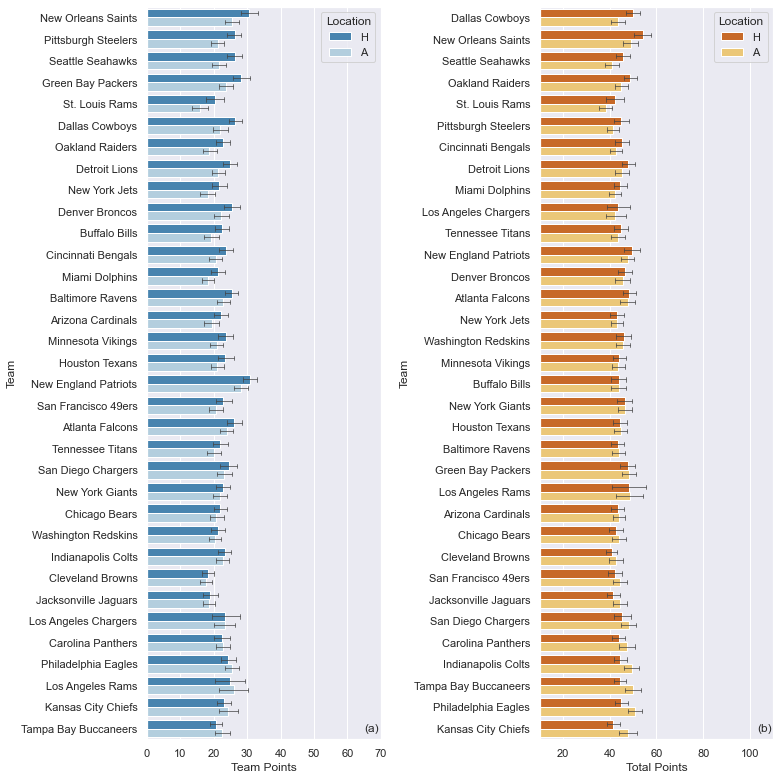

In [214]:
fig11 = plt.figure(figsize=(11,11))
ax1 = fig11.add_subplot(1,2,1)
_ = plt.xlabel('Team Points')
_ = plt.ylabel('Team')
_ = plt.xlim(0,70)
sns.set(font_scale=1.0)
sns.barplot(x='Points',y='Team',hue='Location',hue_order=['H','A'],data=tmpts,errwidth=0.7,capsize=0.2,
            palette='Blues_r').set(xlabel='Team Points')
_ = plt.text(0.93,0.01,'(a)',transform=ax1.transAxes,fontsize='medium')
ax2 = fig11.add_subplot(1,2,2)
_ = plt.xlabel('Total Points')
_ = plt.ylabel('Team')
_ = plt.xlim(10,110)
sns.set(font_scale=1.0)
sns.barplot(x='Tot_Pts',y='Team',hue='Location',hue_order=['H','A'],data=totpts,errwidth=0.7,capsize=0.2,
            palette='YlOrBr_r').set(xlabel='Total Points')
_ = plt.text(0.93,0.01,'(b)',transform=ax2.transAxes,fontsize='medium')
fig11.tight_layout()
fig11.show()
fig11.savefig('plots/fig11.png')

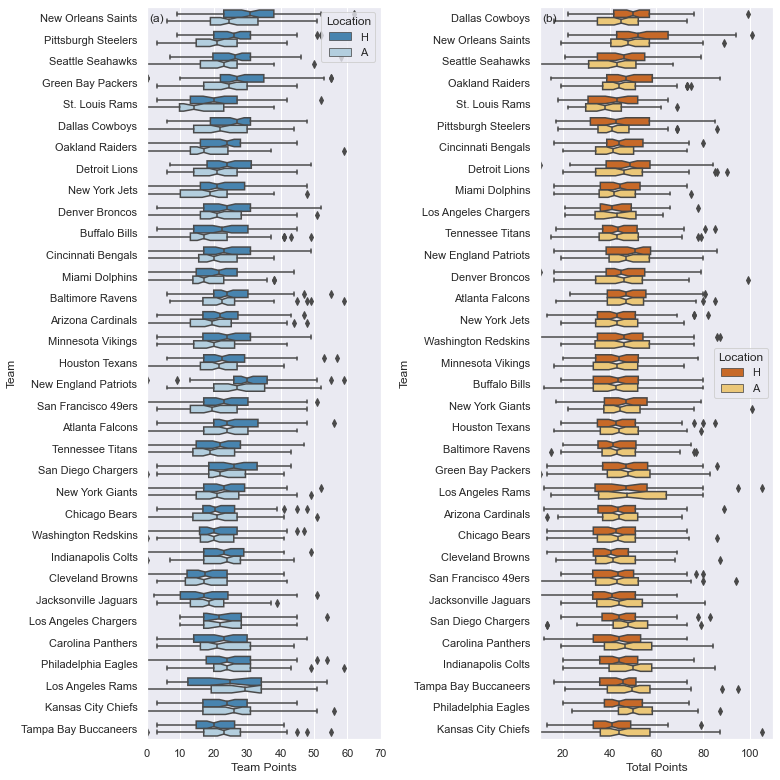

In [331]:
fig11 = plt.figure(figsize=(11,11))
ax1 = fig11.add_subplot(1,2,1)
_ = plt.xlabel('Team Points')
_ = plt.ylabel('Team')
_ = plt.xlim(0,70)
sns.set(font_scale=1.0)
sns.boxplot(x='Points',y='Team',hue='Location',hue_order=['H','A'],data=tmpts,palette='Blues_r',width=0.7,notch='Yes').set(xlabel='Team Points')
_ = plt.text(0.01,0.98,'(a)',transform=ax1.transAxes,fontsize='medium')
ax2 = fig11.add_subplot(1,2,2)
_ = plt.xlabel('Total Points')
_ = plt.ylabel('Team')
_ = plt.xlim(10,110)
sns.set(font_scale=1.0)
sns.boxplot(x='Tot_Pts',y='Team',hue='Location',hue_order=['H','A'],data=totpts,palette='YlOrBr_r',width=0.7,notch='Yes').set(xlabel='Total Points')
_ = plt.text(0.01,0.98,'(b)',transform=ax2.transAxes,fontsize='medium')
fig11.tight_layout()
fig11.show()
#fig11.savefig('plots/fig11.png')

In [448]:
names=['Dallas Cowboys','New Orleans Saints','Seattle Seahawks','Oakland Raiders','Pittsburgh Steelers',
      'Cincinnati Bengals','Detroit Lions','Miami Dolphins']
pts = pd.DataFrame(index=pd.MultiIndex.from_product(
    [names,range(160)],names=['Team','Game']),columns=['Tot_Pts','Over_Under','Location'])
pts.sort_index(ascending=True, inplace=True)
for team in pts.index.levels[0]:
    home_games = len(dfall[dfall.Home_Team==team])
    pts.loc[(team,slice(0,home_games-1)),'Tot_Pts'] = dfall.loc[dfall.Home_Team==team,'Tot_Pts'].values
    pts.loc[(team,slice(0,home_games-1)),'Over_Under'] = dfall.loc[dfall.Home_Team==team,'Over/Under'].values
    pts.loc[(team,slice(0,home_games-1)),'Location'] = 'H'
    vis_games = len(dfall[dfall.Vis_Team==team])
    pts.loc[(team,slice(home_games,home_games+vis_games-1)),'Tot_Pts'] = \
        dfall.loc[dfall.Vis_Team==team,'Tot_Pts'].values
    pts.loc[(team,slice(home_games,home_games+vis_games-1)),'Over_Under'] = \
        dfall.loc[dfall.Vis_Team==team,'Over/Under'].values
    pts.loc[(team,slice(home_games,home_games+vis_games-1)),'Location'] = 'A'
pts['Tot_Pts'] = pd.to_numeric(pts['Tot_Pts'])
pts['Over_Under'] = pd.to_numeric(pts['Over_Under'])
pts.loc[pts.Location=='H','mean_TP_H']=pts[pts.Location=='H'].groupby('Team')['Tot_Pts'].transform(np.mean)
pts.loc[pts.Location=='H','mean_TP_A']=0
pts.loc[pts.Location=='H','mean_OU_H']=pts[pts.Location=='H'].groupby('Team')['Over_Under'].transform(np.mean)
pts.loc[pts.Location=='H','mean_OU_A']=0
pts.loc[pts.Location=='A','mean_TP_A']=pts[pts.Location=='A'].groupby('Team')['Tot_Pts'].transform(np.mean)
pts.loc[pts.Location=='A','mean_TP_H']=0
pts.loc[pts.Location=='A','mean_OU_A']=pts[pts.Location=='A'].groupby('Team')['Over_Under'].transform(np.mean)
pts.loc[pts.Location=='A','mean_OU_H']=0
pts['md_TP']=pts['mean_TP_H']-pts['mean_TP_A']
pts['md_OU']=pts['mean_OU_H']-pts['mean_OU_A']
pts['diff_TP']=pts.groupby('Team')['md_TP'].transform(np.mean)*2.0
pts['diff_OU']=pts.groupby('Team')['md_OU'].transform(np.mean)*2.0

pts = pts.reset_index()
mdpts=pd.DataFrame(index=pts.Team.unique(),columns=['Mean_Diff_TP','Mean_Diff_OU'])
for team,df in pts.groupby('Team'):
    mdpts.loc[team,'Mean_Diff_TP']=df['diff_TP'].mean()
    mdpts.loc[team,'Mean_Diff_OU']=df['diff_OU'].mean()
print(mdpts)
pts=pts.drop(['Game','mean_TP_H','mean_TP_A','mean_OU_H','mean_OU_A','md_TP','md_OU','diff_TP','diff_OU'],axis=1)
melted = pts.melt(id_vars=['Team','Location'])
melted['var']=melted['variable']+'_'+melted['Location']
melted = melted.drop(['variable','Location'],axis=1).rename({'var':'variable'},axis=1)

                    Mean_Diff_TP Mean_Diff_OU
Cincinnati Bengals          2.75      0.01875
Dallas Cowboys             6.225       0.9375
Detroit Lions             2.6375      1.04375
Miami Dolphins             2.075      -0.2625
New Orleans Saints           5.3      0.61875
Oakland Raiders            3.925          0.3
Pittsburgh Steelers         3.45       0.1875
Seattle Seahawks           4.575      -0.0625


In [466]:
over = pd.DataFrame(index=names,columns=['Home_Over','Away_Over'])
for team in over.index:
    df = pts[((pts['Team']==team) & (pts['Location']=='H'))]
    over.loc[team,'Home_Over'] = (df['Tot_Pts'] > df['Over_Under']).mean()
    df = pts[((pts['Team']==team) & (pts['Location']=='A'))]
    over.loc[team,'Away_Over'] = (df['Tot_Pts'] > df['Over_Under']).mean()

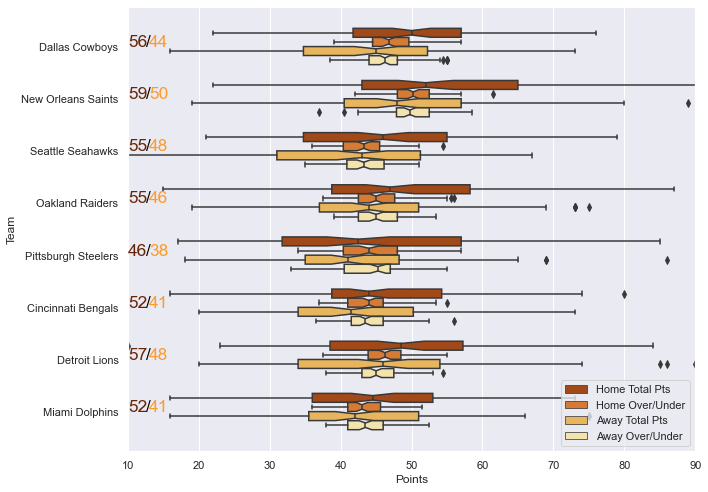

In [467]:
fig13 = plt.figure(figsize=(10,7))
_ = plt.xlabel('Points')
_ = plt.xlim(10,90)
sns.set(font_scale=1.0)
ax = sns.boxplot(x='value',y='Team',hue='variable',hue_order=['Tot_Pts_H','Over_Under_H','Tot_Pts_A','Over_Under_A'],
            data=melted,palette='YlOrBr_r',width=0.7,notch='Yes',order=names)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Home Total Pts','Home Over/Under','Away Total Pts','Away Over/Under'])
ax.set(xlabel='Points')
ax.margins(0.05)
COL = MplColorHelper('YlOrBr_r', 0, 10)
for y in range(len(names)):
    _ = plt.text(10,y,'{:d}'.format(round(over.loc[names[y],'Home_Over']*100)),
                 c=COL.get_rgb(0),fontsize='x-large')
    _ = plt.text(12.5,y,'/',c='black',fontsize='x-large')
    _ = plt.text(13,y,'{:d}'.format(round(over.loc[names[y],'Away_Over']*100)),
                 c=COL.get_rgb(5),fontsize='x-large')
fig13.tight_layout()
fig13.show()
fig13.savefig('plots/fig13.png')

In [ ]:
tpmean = (domed['Tot_Pts'].mean(),
          outside[(outside['Wind']<=5)]['Tot_Pts'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Tot_Pts'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Tot_Pts'].mean(),
          outside[(outside['Wind']>20)]['Tot_Pts'].mean())
oumean = (domed['Over/Under'].mean(),
          outside[(outside['Wind']<=5)]['Over/Under'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Over/Under'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Over/Under'].mean(),
          outside[(outside['Wind']>20)]['Over/Under'].mean())

In [99]:
by_week = dfall[['Tot_Pts','Temperature']]
for ind in by_week.index: 
    by_week.loc[ind,'Week_Beg'] = weekofgame(ind)
    by_week.loc[ind,'Year'] = get_year(ind)
grouped_by_year = by_week.groupby(by_week['Year'])
for key, item in grouped_by_year:
    mapping = get_mapping(item,1)
    for code in item.index:
        by_week.loc[code,'Week'] = int(mapping[by_week.loc[code,'Week_Beg']])
by_week['Week'] = by_week['Week'].astype('int')

In [100]:
avg_pts_week = by_week['Tot_Pts'].groupby(by_week['Week']).mean()
avg_temp_week = by_week['Temperature'].groupby(by_week['Week']).mean()

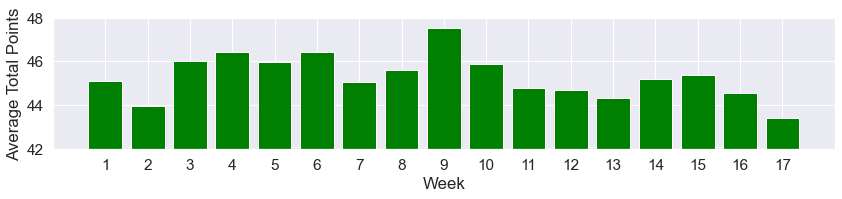

In [102]:
fig9 = plt.figure(figsize=(12,3))
_ = fig9.add_subplot(1,1,1)
_ = plt.xlabel('Week')
_ = plt.ylabel('Average Total Points')
_ = plt.ylim(42,48)
_ = plt.bar(avg_pts_week.index,avg_pts_week.values,color='green',
       tick_label=[str(i) for i in range(1,18)])
#ax2 = ax.twinx()
#ax2.set_ylabel('Temperature (°F)')
#ax2.set_ylim(50,70)
#ax2.plot(avg_temp_week.index,avg_temp_week.values,linewidth=1, color='blue')
#_ = fig9.add_subplot(1,1,1)
#_ = plt.bar()
fig9.tight_layout()  
fig9.show()

In [887]:
domed = dfall[dfall['dome'] == 1]
outside = dfall[dfall['dome'] == 0]

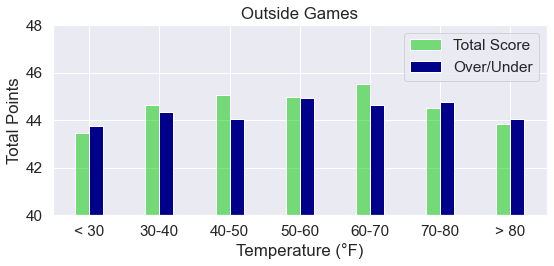

In [909]:
tpmean = (outside[(outside['Temperature']<=30)]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>30) & (outside['Temperature']<=40))]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>40) & (outside['Temperature']<=50))]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>50) & (outside['Temperature']<=60))]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>60) & (outside['Temperature']<=70))]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>70) & (outside['Temperature']<=80))]['Tot_Pts'].mean(),
          outside[(outside['Temperature']>80)]['Tot_Pts'].mean())
oumean = (outside[(outside['Temperature']<=30)]['Over/Under'].mean(),
          outside[((outside['Temperature']>30) & (outside['Temperature']<=40))]['Over/Under'].mean(),
          outside[((outside['Temperature']>40) & (outside['Temperature']<=50))]['Over/Under'].mean(),
          outside[((outside['Temperature']>50) & (outside['Temperature']<=60))]['Over/Under'].mean(),
          outside[((outside['Temperature']>60) & (outside['Temperature']<=70))]['Over/Under'].mean(),
          outside[((outside['Temperature']>70) & (outside['Temperature']<=80))]['Over/Under'].mean(),
          outside[(outside['Temperature']>80)]['Over/Under'].mean())

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

ind = np.arange(7)  # the x locations for the groups
width = 0.2  # the width of the bars

sns.set(font_scale=1.4)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score',color=(0,0.8,0,0.5))
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under',color='darkblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Total Points')
#_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.xlabel('Temperature (°F)')
_ = plt.title('Outside Games')
_ = plt.legend(loc='upper right')
_ = plt.ylim(40,48)
fig.tight_layout()
fig.show()

In [898]:
(outside[(outside['Temperature']<=30)]['Tot_Pts'].count(),
          outside[((outside['Temperature']>30) & (outside['Temperature']<=40))]['Tot_Pts'].count(),
          outside[((outside['Temperature']>40) & (outside['Temperature']<=50))]['Tot_Pts'].count(),
          outside[((outside['Temperature']>50) & (outside['Temperature']<=60))]['Tot_Pts'].count(),
          outside[((outside['Temperature']>60) & (outside['Temperature']<=70))]['Tot_Pts'].count(),
          outside[((outside['Temperature']>70) & (outside['Temperature']<=80))]['Tot_Pts'].count(),
          outside[(outside['Temperature']>80)]['Tot_Pts'].count())

(172, 207, 188, 377, 434, 320, 188)

In [786]:
gr_by_t['Tot_Pts'].count()

Wind
(0, 5]      525
(5, 10]     782
(10, 20]    462
(20, 80]     35
Name: Tot_Pts, dtype: int64

In [911]:
outside[(outside['Wind']<=5)]['Tot_Pts'].mean()

46.237232289950576

In [912]:
outside[(outside['Wind']<=5)]['Over/Under'].mean()

44.78665568369028

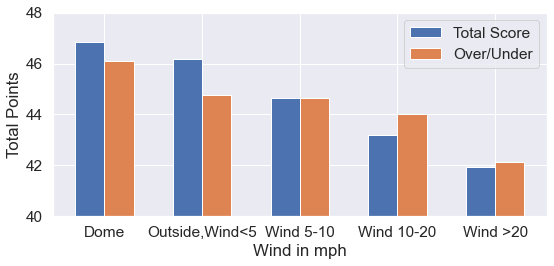

In [872]:
tpmean = (domed['Tot_Pts'].mean(),
          outside[(outside['Wind']<=5)]['Tot_Pts'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Tot_Pts'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Tot_Pts'].mean(),
          outside[(outside['Wind']>20)]['Tot_Pts'].mean())
oumean = (domed['Over/Under'].mean(),
          outside[(outside['Wind']<=5)]['Over/Under'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Over/Under'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Over/Under'].mean(),
          outside[(outside['Wind']>20)]['Over/Under'].mean())

fig10 = plt.figure(figsize=(8,4))
ax = fig10.add_subplot(1,1,1)

ind = np.arange(5)  # the x locations for the groups
width = 0.3  # the width of the bars

sns.set(font_scale=1.4)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Total Points')
#_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside,Wind<5','Wind 5-10','Wind 10-20','Wind >20'))
_ = plt.xlabel('Wind in mph')
_ = plt.legend(loc='upper right')
_ = plt.ylim(40,48)
fig10.show()
fig10.tight_layout()
fig10.savefig('plots/fig10.png')

In [847]:
dfout=dfall[['Tot_Pts','Over/Under','dome','Wind']]
dfout.loc[dfout['dome']==1,'Desc'] = 'Dome'
dfout.loc[((dfout['dome']==0)&(dfout['Wind']<5)),'Desc'] = 'Outside,Wind<5'
dfout.loc[((dfout['Wind']>=5)&(dfout['Wind']<10)),'Desc'] = 'Wind 5-10'
dfout.loc[((dfout['Wind']>=10)&(dfout['Wind']<20)),'Desc'] = 'Wind 10-20'
dfout.loc[(dfout['Wind']>=20),'Desc'] = 'Wind >20'
dfout.drop(['dome','Wind'],axis=1,inplace=True)
dfout=pd.melt(dfout,id_vars=['Desc'],value_vars=['Tot_Pts','Over/Under'],
              var_name='Feature')

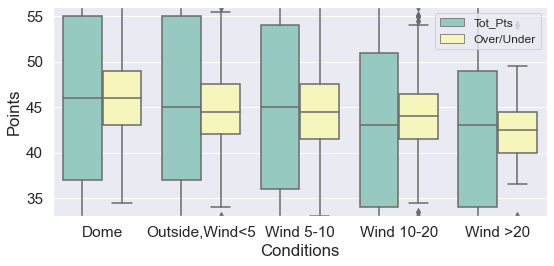

In [870]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
_ = sns.boxplot(x='Desc',y='value',hue='Feature',data=dfout,orient='v',palette='Set3',
           order=['Dome','Outside,Wind<5','Wind 5-10','Wind 10-20','Wind >20']).set(xlabel='Conditions',
                                                                                    ylabel='Points',
                                                                                    ylim=(33,56))
_ = ax.legend(loc='upper right',fontsize=12)
_ = fig.tight_layout()
_ = fig.show()

                     Mean_Home_Wind Mean_Away_Wind  Home_Over  Away_Over
Cleveland Browns            12.7625         6.2375  41.250000   48.75000
Miami Dolphins                 11.2            6.7  52.500000   41.25000
Buffalo Bills               10.2875         7.2875  51.250000   45.00000
Chicago Bears                   9.9         5.3875  46.250000   52.50000
Philadelphia Eagles           9.375         5.0375  42.500000   61.25000
Green Bay Packers            9.0625         5.2375  52.500000   53.75000
Pittsburgh Steelers           8.675         7.8125  46.250000   37.50000
Kansas City Chiefs           8.5375          5.875  36.250000   50.00000
New England Patriots        8.53165            7.2  59.493671   48.75000
Oakland Raiders              8.4375         7.0375  55.000000   46.25000
New York Jets                8.1625        8.82278  51.250000   54.43038
Tampa Bay Buccaneers          8.125            3.7  47.500000   57.50000
Baltimore Ravens             7.8375          6.975 

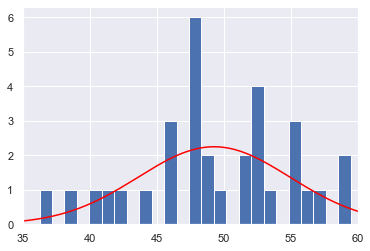

In [525]:
wind=pd.DataFrame(index=teams,columns=['Mean_Home_Wind','Mean_Away_Wind','Home_Over','Away_Over'])
for team in teams:
    if (team not in ['St. Louis Rams','San Diego Chargers']):
        if team == 'Los Angeles Rams':
            df=pd.concat([dfall[dfall['Home_Team']==team],dfall[dfall['Home_Team']=='St. Louis Rams']])
        elif team == 'Los Angeles Chargers':
            df=pd.concat([dfall[dfall['Home_Team']==team],dfall[dfall['Home_Team']=='San Diego Chargers']])
        else:
            df=dfall[dfall['Home_Team']==team]
        wind.loc[team,'Mean_Home_Wind']=df['Wind'].mean()
        wind.loc[team,'Home_Over']=(df['Tot_Pts']>df['Over/Under']).mean()
        df=dfall[dfall['Vis_Team']==team]
        wind.loc[team,'Mean_Away_Wind']=df['Wind'].mean()
        wind.loc[team,'Away_Over']=(df['Tot_Pts']>df['Over/Under']).mean()
wind=wind.drop(['St. Louis Rams','San Diego Chargers'])
wind['Home_Over']=(100*pd.to_numeric(wind['Home_Over']))
wind['Away_Over']=(100*pd.to_numeric(wind['Away_Over']))
wind = wind.sort_values(by='Mean_Home_Wind',ascending=False)
print(wind)
plt.hist(wind['Home_Over'],bins=25)
plt.xlim(35,60)
xx = np.linspace(35,65,500)
yy = len(wind)*stats.norm.pdf(xx,loc=np.mean(wind['Home_Over']),scale=np.std(wind['Home_Over']))
plt.plot(xx,yy,c='red')
plt.show()

In [485]:
wind=pd.DataFrame(index=teams,columns=['Mean_Home_Wind','Mean_Away_Wind','Home_Over','Away_Over'])
for team in teams:
    df=dfall[dfall['Home_Team']==team]
    wind.loc[team,'Mean_Home_Wind']=df['Wind'].mean()
    wind.loc[team,'Home_Over']=(df['Tot_Pts']>df['Over/Under']).mean()
    df=dfall[dfall['Vis_Team']==team]
    wind.loc[team,'Mean_Away_Wind']=df['Wind'].mean()
    wind.loc[team,'Away_Over']=(df['Tot_Pts']>df['Over/Under']).mean()
wind['Home_Over']=(100*pd.to_numeric(wind['Home_Over']))
wind['Away_Over']=(100*pd.to_numeric(wind['Away_Over']))
wind = wind.sort_values(by='Mean_Home_Wind',ascending=False)
print(wind)

                     Mean_Home_Wind Mean_Away_Wind  Home_Over  Away_Over
Cleveland Browns            12.7625         6.2375  41.250000  48.750000
Miami Dolphins                 11.2            6.7  52.500000  41.250000
Buffalo Bills               10.2875         7.2875  51.250000  45.000000
Chicago Bears                   9.9         5.3875  46.250000  52.500000
Philadelphia Eagles           9.375         5.0375  42.500000  61.250000
Green Bay Packers            9.0625         5.2375  52.500000  53.750000
Pittsburgh Steelers           8.675         7.8125  46.250000  37.500000
Kansas City Chiefs           8.5375          5.875  36.250000  50.000000
New England Patriots        8.53165            7.2  59.493671  48.750000
Oakland Raiders              8.4375         7.0375  55.000000  46.250000
New York Jets                8.1625        8.82278  51.250000  54.430380
Tampa Bay Buccaneers          8.125            3.7  47.500000  57.500000
Baltimore Ravens             7.8375          6.975 

In [540]:
wind['Home_Over'].std()

5.77247204142507

In [541]:
kc = dfall[dfall['Home_Team']=='Kansas City Chiefs']
(kc['Tot_Pts']<kc['Over/Under']).mean()

0.625

In [535]:
ser=pd.Series(index=teams)
for team in teams:
    home = dfall[dfall.Home_Team==team]
    away = dfall[dfall.Vis_Team==team]
    diff = home['Over/Under'].mean() - away['Over/Under'].mean()
    ser[team] = abs(diff)
print(ser.sort_values(ascending=False))
print(ser.mean())

Green Bay Packers       1.087500
Detroit Lions           1.043750
Dallas Cowboys          0.937500
Atlanta Falcons         0.843750
Washington Redskins     0.712500
New Orleans Saints      0.618750
Kansas City Chiefs      0.506250
Indianapolis Colts      0.481250
Buffalo Bills           0.418750
Los Angeles Chargers    0.375000
San Francisco 49ers     0.368750
Baltimore Ravens        0.356250
New York Jets           0.356013
Cleveland Browns        0.312500
San Diego Chargers      0.312500
Oakland Raiders         0.300000
St. Louis Rams          0.281250
Minnesota Vikings       0.268750
Miami Dolphins          0.262500
Tampa Bay Buccaneers    0.256250
Los Angeles Rams        0.250000
Carolina Panthers       0.231250
Denver Broncos          0.212500
New England Patriots    0.209968
Pittsburgh Steelers     0.187500
Chicago Bears           0.106250
New York Giants         0.100000
Jacksonville Jaguars    0.075000
Seattle Seahawks        0.062500
Philadelphia Eagles     0.050000
Tennessee 

In [511]:
import pingouin as pg
res = pg.ttest(ntot_home['Tot_Pts']>ntot_home['Over/Under'],(dfall['Tot_Pts']>dfall['Over/Under']).mean(),
              tail='one-sided')
print(res)

              T  dof     tail     p-val       CI95%   cohen-d  BF10     power
T-test  1.71034   79  greater  0.045564  [0.5, inf]  0.191222  0.99  0.520263


In [156]:
surf_cols=['a_turf','astroplay','fieldturf','grass','matrixturf','sportturf']
X_show['astroturf'] = 1-X_show[surf_cols].sum(axis=1)
surf_cols.append('astroturf')
surface = pd.concat([X_show[['Tot_Pts']],X_show[surf_cols]],axis=1)
by_surface = combine_dummies(surface,'surface',surf_cols)
avg_pts_surf=by_surface['Tot_Pts'].groupby(by_surface['surface']).mean()
count_surf = by_surface['Tot_Pts'].groupby(by_surface['surface']).count()
count_surf

KeyError: "['a_turf', 'sportturf', 'astroplay', 'fieldturf', 'matrixturf'] not in index"

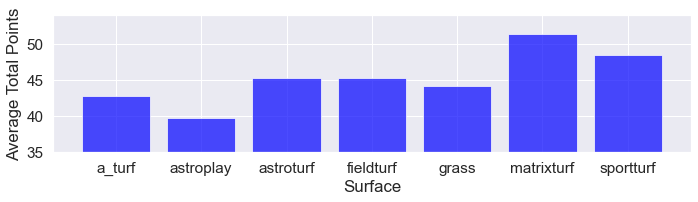

In [847]:
fig = plt.figure(figsize=(10,3))
ax = fig10.add_subplot(1,1,1)
ax.set_xlabel('Surface')
ax.set_ylabel('Average Total Points')
ax.set_ylim(35,54)
ax.bar(avg_pts_surf.index,avg_pts_surf.values,color='blue',alpha=0.7)
fig.show()
fig.tight_layout()
fig.savefig('plots/fig10.png')

In [389]:
by_team = pd.DataFrame(index=teams.keys())
grouped_by_home = dfall.groupby(dfall['Home_Team'])
grouped_by_vis = dfall.groupby(dfall['Vis_Team'])
for key, item in grouped_by_home:
    by_team.loc[key,'Avg Home Team Score'] = round(item['H_Game'].mean(),3)
    by_team.loc[key,'Avg Home Total Score'] = round(item['Tot_Pts'].mean(),3)
for key,item in grouped_by_vis:
    by_team.loc[key,'Avg Vis Team Score'] = round(item['V_Game'].mean(),3)
    by_team.loc[key,'Avg Vis Total Score'] = round(item['Tot_Pts'].mean(),3)
by_team['Avg Team Score'] = (by_team['Avg Home Team Score'] + by_team['Avg Vis Team Score'])/2.0
by_team['Team Home - Vis'] = by_team['Avg Home Team Score'] - by_team['Avg Vis Team Score']
by_team['Total Home - Vis'] = by_team['Avg Home Total Score'] - by_team['Avg Vis Total Score']
by_team = by_team[['Avg Home Team Score','Avg Vis Team Score','Avg Team Score','Team Home - Vis',
                   'Avg Home Total Score','Avg Vis Total Score','Total Home - Vis']]
by_team.sort_values(by=['Avg Team Score'],ascending=False)

,Avg Home Team Score,Avg Vis Team Score,Avg Team Score,Team Home - Vis,Avg Home Total Score,Avg Vis Total Score,Total Home - Vis
New England Patriots,30.785,28.125,29.4550,2.660,49.392,47.812,1.580
New Orleans Saints,30.625,25.550,28.0875,5.075,54.350,49.050,5.300
Green Bay Packers,28.262,23.688,25.9750,4.574,47.763,48.175,-0.412
Los Angeles Rams,24.750,25.969,25.3595,-1.219,48.125,48.562,-0.437
Atlanta Falcons,26.038,23.913,24.9755,2.125,48.350,47.663,0.687
Philadelphia Eagles,24.400,25.400,24.9000,-1.000,45.000,50.913,-5.913
Dallas Cowboys,26.363,21.988,24.1755,4.375,49.938,43.712,6.226
Baltimore Ravens,25.425,22.675,24.0500,2.750,43.413,43.788,-0.375
Seattle Seahawks,26.238,21.637,23.9375,4.601,45.587,41.013,4.574
San Diego Chargers,24.518,23.179,23.8485,1.339,45.161,48.357,-3.196


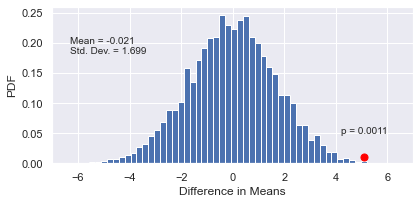

In [360]:
nor_home = dfall[dfall['Home_Team']=='New Orleans Saints']
nor_away = dfall[dfall['Vis_Team']=='New Orleans Saints']
nor_mean_diff = permuted(nor_home['H_Game'],nor_away['V_Game'],diff_of_means)

p = 1.0 - stats.percentileofscore(nor_mean_diff,5.075)/100

mu = np.mean(nor_mean_diff)
sd = np.std(nor_mean_diff)

ymax = 0.26
y1 = ymax
y2 = 0.0
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
_ = plt.hist(nor_mean_diff,bins=55,density=True,label='Seasonal mean Over%',zorder=1)
_ = plt.ylim(0,ymax)
_ = plt.xlim(-7,7)
ax.text(0.05,0.7,'Mean = {0:.3f}\nStd. Dev. = {1:.3f}'.format(mu,sd),transform=ax.transAxes,fontsize='small')
ax.text(4.2,0.05,'p = {:.4f}'.format(p),fontsize='small')
_ = plt.xlabel('Difference in Means')
_ = plt.ylabel('PDF')
_ = plt.scatter(5.075,0.01,marker='.',color='red',s=200,zorder=2)
fig.tight_layout()
fig.show()

mu = 0.027, sd = 2.447, p = 0.015


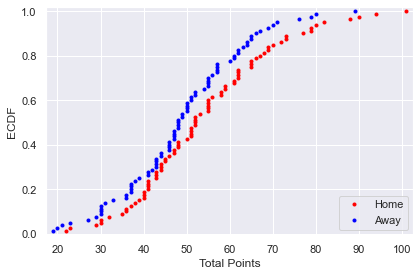

In [387]:
ntot_home = dfall[dfall['Home_Team']=='New Orleans Saints']
ntot_away = dfall[dfall['Vis_Team']=='New Orleans Saints']
ntot_mean_diff = permuted(ntot_home['Tot_Pts'],ntot_away['Tot_Pts'],diff_of_means)

p = 1.0 - stats.percentileofscore(ntot_mean_diff,5.300)/100
fig12 = plt.figure(figsize=(6,4))

mu = np.mean(ntot_mean_diff)
sd = np.std(ntot_mean_diff)

for _ in range(100):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(ntot_home['Tot_Pts'],ntot_away['Tot_Pts'])


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

#     # Plot ECDFs of permutation sample
#     _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
#                  color='red', alpha=0.02)
#     _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
#                  color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(ntot_home['Tot_Pts'])
x_2, y_2 = ecdf(ntot_away['Tot_Pts'])
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red',label='Home')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue',label='Away')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Total Points')
_ = plt.ylabel('ECDF')
_ = plt.legend(loc='lower right')
fig12.tight_layout()
fig12.show()
fig12.savefig('plots/fig12.png')
print('mu = {0:.3f}, sd = {1:.3f}, p = {2:.3f}'.format(mu,sd,p))

In [238]:
domed = X_show[X_show['dome']==1]
notdomed = X_show[X_show['dome']==0]

In [169]:
print(X_show['Tot_Pts'].corr(X_show['Wind']))
print(X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(np.log(X_show['Wind'])))
print(X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(np.sqrt(X_show['Wind'])))
print(X_show[X_show['Wind'] > 0]['Tot_Pts'].corr((X_show['Wind'])**(-1.0)))
print(X_show[X_show['Wind'] > 0]['Tot_Pts'].corr((X_show['Wind'])**(-0.5)))

-0.10503186504651046
-0.11904889589650075
-0.11375883008230511
0.11618033708929379
0.12005030510087619


In [377]:
ridge=Ridge(alpha=0.08,normalize=True)
regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=True,return_metrics=False)

MAE_train = 10.566±0.417, Accuracy = 0.541±0.024
MAE_test = 10.636, Accuracy_test = 0.567
